In [15]:
import numpy as np
import time
import os
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.constraints import non_neg
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, UpSampling1D, UpSampling2D, UpSampling3D
from keras.layers import Conv2D, Conv1D, MaxPooling2D, BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import backend
from scipy import misc
from keras.models import model_from_json
from skimage.transform import resize

##Modify Parameters Here
bands=3
hr_img_size=(32,32)
inpt_lr_img_size=(10,10)
sptlvarmeasure=32









# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train=X_train.copy()
y_test=X_test.copy()
newximglist=[]
newx2imglist=[]
imagecounter=0
for image in X_train:
    preimage=np.swapaxes(image.copy(),0,2)
    preimage=np.swapaxes(preimage,0,1)
    newximage=misc.imresize(preimage, inpt_lr_img_size)
    newximage=np.swapaxes(newximage,0,2)
    newximage=np.swapaxes(newximage,1,2)
    newximglist.append(newximage)
    imagecounter+=1
X_train=np.array(newximglist)
for image in X_test:
    preimage=np.swapaxes(image.copy(),0,2)
    preimage=np.swapaxes(preimage,0,1)
    newximage=misc.imresize(preimage, inpt_lr_img_size)
    newximage=np.swapaxes(newximage,0,2)
    newximage=np.swapaxes(newximage,1,2)
    newx2imglist.append(newximage.copy())
    imagecounter+=1
X_test=np.array(newx2imglist)
y_train=np.swapaxes(y_train,1,-1)
y_test=np.swapaxes(y_test,1,-1)
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
# 5. Preprocess input data
print(X_train.shape)
print(y_train.shape)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')[0:10] 
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')[0:10]
X_train /= 255
X_test /= 255
y_train /= 255
y_test /= 255


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(10000, 3, 10, 10)
(50000, 3, 10, 10)
(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 3, 10, 10)
(50000, 3, 32, 32)


In [16]:

 
# 7. Define model architecture
model = Sequential()
ilis=inpt_lr_img_size[0]
model.add(Conv2D(filters=ilis*4/5, kernel_size=(2, 2), data_format='channels_first', activation='relu', kernel_constraint=non_neg(), padding='valid', input_shape=(bands,ilis,ilis)))
model.add(Conv2D(filters=ilis*4/5, kernel_size=(2, 2), data_format='channels_first', activation='relu', kernel_constraint=non_neg(), padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=ilis*9/5, kernel_size=(2, 2), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(Conv2D(filters=ilis*9/5, kernel_size=(2, 2), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=ilis*16/5, kernel_size=(2, 2), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(Conv2D(filters=ilis*16/5, kernel_size=(2, 2), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Conv2D(filters=ilis*32/5, kernel_size=(1, 1), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(Conv2D(filters=ilis*32/5, kernel_size=(1, 1), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), data_format='channels_first'))
model.add(Dropout(0.35))

model.add(UpSampling2D((6,6),data_format='channels_first'))
model.add(Conv2D(filters=ilis*32/5, kernel_size=(1, 1), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=ilis*32/5, kernel_size=(2, 2), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D((3,3),data_format='channels_first'))
model.add(Conv2D(filters=ilis*16/5, kernel_size=(1, 1), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=ilis*16/5, kernel_size=(2, 2), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=ilis*4/5, kernel_size=(1, 1), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=ilis*3/10, kernel_size=(1, 1), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())



 
# 8. Compile model
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])





In [17]:
print(y_train.shape)
print(model.summary())

(50000, 3, 32, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 8, 9, 9)           104       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 8)           264       
_________________________________________________________________
batch_normalization_40 (Batc (None, 8, 8, 8)           32        
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 18, 7, 7)          594       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 18, 6, 6)          1314      
_________________________________________________________________
batch_normalization_41 (Batc (None, 18, 6, 6)          24

In [19]:
if os.path.isfile('model.json'):
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")
opt = optimizers.Adam(lr=.01, beta_1=0.9, beta_2=0.999, epsilon=.000001, decay=0.0)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
print(X_train.shape)
tensorboard = TensorBoard(log_dir=os.getcwd()+'/logs'.format(time.time()))
writer = tf.summary.FileWriter(os.getcwd()+'/logs').add_graph(sess.graph)
try:
  loaded_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
  loaded_model.fit(X_train, y_train, 
              batch_size=96, nb_epoch=3, verbose=1, callbacks=[tensorboard])
  model=loaded_model
except (NameError, ValueError) as e:
    model.fit(X_train, y_train, 
              batch_size=96, nb_epoch=3, verbose=1, callbacks=[tensorboard])
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")




Loaded model from disk
(50000, 3, 10, 10)
Epoch 1/3
50000/50000 [==============================] - 43s 851us/step - loss: 54.7669 - acc: 0.0257
Epoch 2/3
50000/50000 [==============================] - 42s 842us/step - loss: 53.5803 - acc: 0.0285
Epoch 3/3
50000/50000 [==============================] - 42s 841us/step - loss: 52.4932 - acc: 0.0241
Saved model to disk


In [99]:
score = model.evaluate(X_test, y_test, verbose=1)
class_scores= model.predict(X_test)
print(score)

10/10 [==============================] - 5s 475ms/step
[121.40303039550781, 0.0072916666977107525]


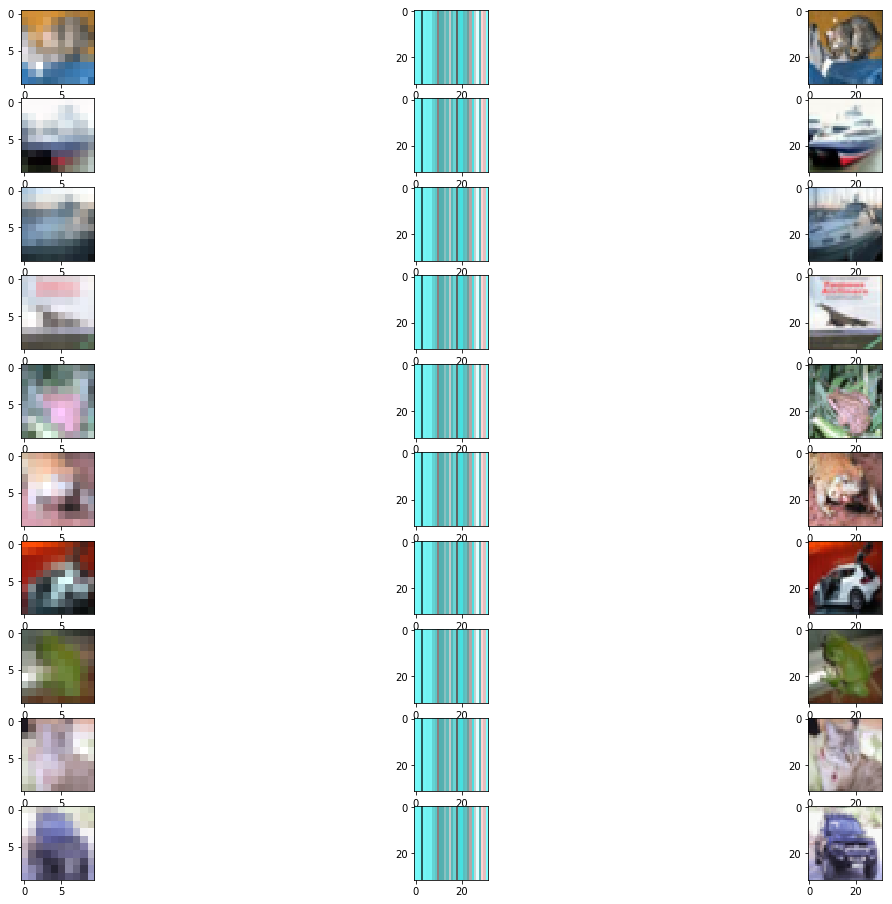

In [100]:
import matplotlib.pyplot as plt
classes=[]
for image in class_scores:
    thisclass=image
    classes.append(thisclass)
f, ax = plt.subplots(10,3, figsize=(20, 16))
axind0=0
axind1=0
imagecounter=0
for image in X_test:
    axind0=imagecounter
    emptyximage=np.zeros((10,10,3))
    emptyyimage=np.zeros((32,32,3))
    emptytargetimage=np.zeros((32,32,3))
    for band in range(1,4):
        newximage=np.abs(image[band-1:band,0:10,0:10])
        newtargetimage=y_test[imagecounter][band-1:band,0:32,0:32]
        newyimage=np.abs(classes[imagecounter][band-1:band,0:32,0:32])
        emptyximage[:,:,band-1:band]=newximage.reshape((10,10,1))*(1/np.max(newximage))
        emptyyimage[:,:,band-1:band]=newyimage.reshape((32,32,1))*(1/np.max(newyimage))
        emptytargetimage[:,:,band-1:band]=newtargetimage.reshape((32,32,1))*(1/np.max(newtargetimage))
    imagecounter+=1
    ax[axind0,0].imshow(emptyximage)
    ax[axind0,1].imshow(emptyyimage)
    ax[axind0,2].imshow(emptytargetimage)
    
    
    